<div class="alert alert-block alert-warning">
<b>Costs:</b> This QPU simulation costs $37,8 US dollars (Ankaa-3 Rigetti).
18 iterations: $5,4
2000 shots/interation: $1,8
total cost: $37,8
</div>

<div class="alert alert-block alert-success">
<b>This simulation finds ground state energy for H2 molecule. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [2]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name='default')

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Defining the function to save results to json file and read results from file

In [3]:
import json

def save_to_file(data, file_name):
    with open(file_name+".json", "w") as file:
        json.dump(data, file, indent=4)

def read_from_file(file_name):
    with open(file_name+".json", 'r') as file:
        data = json.load(file)
    return data

# Importando Backends - Computadores Quânticos

In [4]:
from braket.aws import AwsDevice

for d in AwsDevice.get_devices():
    print(f"{d.name:20}  |  {d.provider_name:10} |  {d.arn}")

Ankaa-3               |  Rigetti    |  arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3
Aquila                |  QuEra      |  arn:aws:braket:us-east-1::device/qpu/quera/Aquila
Aria 1                |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1
Aria 2                |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2
Emerald               |  IQM        |  arn:aws:braket:eu-north-1::device/qpu/iqm/Emerald
Forte 1               |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1
Forte Enterprise 1    |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Forte-Enterprise-1
Garnet                |  IQM        |  arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet
SV1                   |  Amazon Braket |  arn:aws:braket:::device/quantum-simulator/amazon/sv1
TN1                   |  Amazon Braket |  arn:aws:braket:::device/quantum-simulator/amazon/tn1
dm1                   |  Amazon Braket |  arn:aws:braket:::device/quantum-simulator/ama

In [18]:
shots  = 2000 
device_arn = "arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3" 

# PES H2 (Obter a energia em QPU de pontos já otimizados)

/Users/nara/Repository/Attention/Sampa-USP/AbInitio/.venv/lib/python3.12/site-packages/pennylane/devices/legacy_facade.py:177: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


01/18  R=0.500 Å  params=[0.09329 0.      0.     ]  E_device = 1.94737228 Ha
02/18  R=0.750 Å  params=[0.117975 0.       0.      ]  E_device = 1.08545175 Ha
03/18  R=1.000 Å  params=[0.151794 0.       0.      ]  E_device = 0.54344082 Ha
04/18  R=1.250 Å  params=[0.1946 0.     0.    ]  E_device = 0.24782505 Ha
05/18  R=1.500 Å  params=[0.247235 0.       0.      ]  E_device = 0.01944334 Ha
06/18  R=1.750 Å  params=[0.310672 0.       0.      ]  E_device = -0.12446970 Ha
07/18  R=2.000 Å  params=[0.385631 0.       0.      ]  E_device = -0.22905747 Ha
08/18  R=2.250 Å  params=[0.473498 0.       0.      ]  E_device = -0.32324652 Ha
09/18  R=2.500 Å  params=[0.574331 0.       0.      ]  E_device = -0.38053468 Ha
10/18  R=2.750 Å  params=[0.684537 0.       0.      ]  E_device = -0.40951832 Ha
11/18  R=3.000 Å  params=[0.799838 0.       0.      ]  E_device = -0.44306066 Ha
12/18  R=3.250 Å  params=[0.913927 0.       0.      ]  E_device = -0.47445496 Ha
13/18  R=3.500 Å  params=[1.021756 0.     

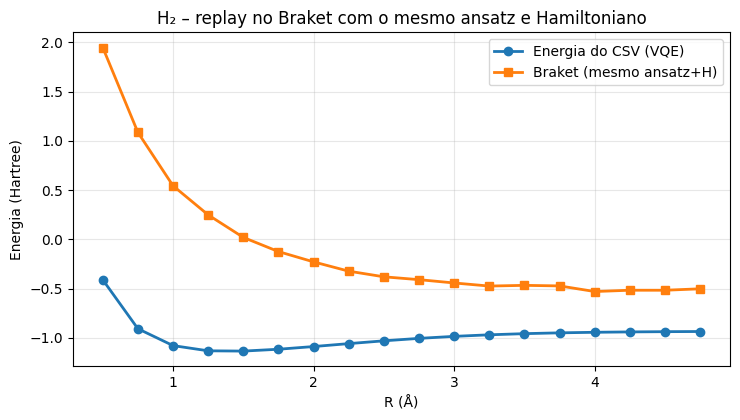

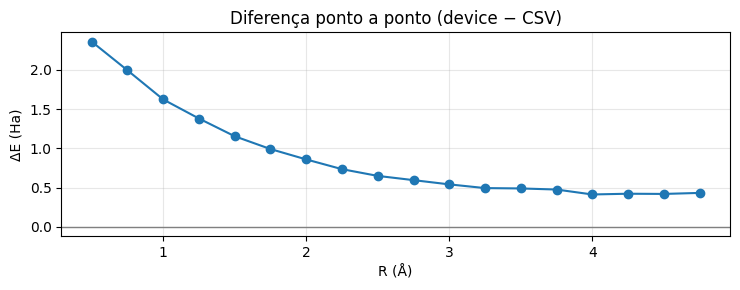

In [15]:
# =========================================================
# Replay do VQE no Braket (mesmo ansatz e Hamiltoniano)
# Lê CSV (R, energia_sim, ângulos) e mede <H> no SV1/QPU
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pennylane as qml
from pennylane import qchem

# ------------------ CONFIG ------------------
csv_in  = "pes_vqe_resultados.csv"      # entrada com R e ângulos
csv_out = "pes_vqe_replay_braket.csv"   # saída com energia do device

shots = 2000

# Geometria H2 (H em z), unidades em Å (default do qchem)
symbols = ["H", "H"]

# -------------------------------------------
# Funções auxiliares
# -------------------------------------------
def read_params_from_row(row):
    """Aceita CSV com 1 ou 3 ângulos. Retorna np.array([θ0, θ1, θ2])."""
    # nomes aceitáveis (ajuste se o seu CSV tiver outros cabeçalhos)
    possible_1 = ["Ângulo θ (rad)", "theta", "theta (rad)"]
    possible_3 = [("Ângulo 0 (rad)", "Ângulo 1 (rad)", "Ângulo 2 (rad)"),
                  ("theta0", "theta1", "theta2")]
    # tenta 3 ângulos
    for a0, a1, a2 in possible_3:
        if a0 in row and a1 in row and a2 in row:
            return np.array([float(row[a0]), float(row[a1]), float(row[a2])], dtype=float)
    # tenta 1 ângulo
    for a in possible_1:
        if a in row:
            return np.array([float(row[a]), 0.0, 0.0], dtype=float)
    raise ValueError("CSV não contém colunas de ângulo reconhecidas.")

def geometry_from_R(R_ang):
    # H em (0,0,0) e (0,0,R)
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, float(R_ang)], dtype=float)

# -------------------------------------------
# Loop: para cada R do CSV, monta H, QNode e avalia no Braket
# -------------------------------------------
df = pd.read_csv(csv_in)

# Detecta colunas básicas
col_R = [c for c in df.columns if "R" in c][0]               # ex: "R (Å)"
col_Esim = [c for c in df.columns if "Energia" in c][0]      # ex: "Energia (Ha)"

energies_device = []
details = []

for i, row in df.iterrows():
    R = float(row[col_R])
    params = read_params_from_row(row)

    # --- Hamiltoniano molecular (PySCF via PennyLane) para ESTE R ---
    coords = geometry_from_R(R)
    H, n_qubits = qchem.molecular_hamiltonian(
        symbols, coords, method="pyscf"  # Å por default
    )

    # --- estado HF para n_qubits (2 elétrons em H2) ---
    hf = qchem.hf_state(electrons=2, orbitals=n_qubits)

    # --- device Braket ---
    dev = qml.device("braket.aws.qubit", device_arn=device_arn, wires=n_qubits, shots=shots)

    # --- QNode: mesmo ansatz do seu VQE ---
    @qml.qnode(dev, interface="autograd")
    def circuit(theta):
        # HF: |1100> (para 4 qubits) conforme mapeamento
        qml.BasisState(hf, wires=range(n_qubits))
        # UCCSD “mínimo” do seu exemplo
        qml.DoubleExcitation(theta[0], wires=[0, 1, 2, 3])
        qml.SingleExcitation(theta[1], wires=[0, 2])
        qml.SingleExcitation(theta[2], wires=[1, 3])
        return qml.expval(H)

    # --- avalia no device ---
    E_dev = float(circuit(params))
    energies_device.append(E_dev)

    print(f"{i+1:02d}/{len(df)}  R={R:.3f} Å  "
          f"params={np.array2string(params, precision=6)}  "
          f"E_device = {E_dev:.8f} Ha")

# -------------------------------------------
# Salva e plota
# -------------------------------------------
df["Energia_device (Ha)"] = energies_device
df["ΔE (device - sim)"] = df["Energia_device (Ha)"] - df[col_Esim]
df.to_csv(csv_out, index=False)
print(f"\n💾 Resultado salvo em {csv_out}")

plt.figure(figsize=(7.5,4.3))
plt.plot(df[col_R], df[col_Esim], "o-", lw=2, label="Energia do CSV (VQE)")
plt.plot(df[col_R], df["Energia_device (Ha)"], "s-", lw=2, label="Braket (mesmo ansatz+H)")
plt.xlabel("R (Å)"); plt.ylabel("Energia (Hartree)")
plt.title("H₂ – replay no Braket com o mesmo ansatz e Hamiltoniano")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7.5,3.0))
plt.plot(df[col_R], df["ΔE (device - sim)"], "o-", lw=1.5)
plt.axhline(0, color="gray", lw=1)
plt.xlabel("R (Å)"); plt.ylabel("ΔE (Ha)")
plt.title("Diferença ponto a ponto (device − CSV)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

/Users/nara/Repository/Attention/Sampa-USP/AbInitio/.venv/lib/python3.12/site-packages/pennylane/devices/legacy_facade.py:177: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


01/18  R=0.50 Å | E(s=1)= 0.607168  E_ZNE= 0.607168  [E3= 0.425213, E5= 0.344518]
02/18  R=0.75 Å | E(s=1)= 0.007050  E_ZNE= 0.007050  [E3=-0.036489, E5=-0.099868]
03/18  R=1.00 Å | E(s=1)=-0.255103  E_ZNE=-0.255103  [E3=-0.313555, E5=-0.326464]
04/18  R=1.25 Å | E(s=1)=-0.387004  E_ZNE=-0.387004  [E3=-0.413359, E5=-0.421776]
05/18  R=1.50 Å | E(s=1)=-0.459897  E_ZNE=-0.459897  [E3=-0.493795, E5=-0.484905]
06/18  R=1.75 Å | E(s=1)=-0.489013  E_ZNE=-0.489013  [E3=-0.515524, E5=-0.514047]
07/18  R=2.00 Å | E(s=1)=-0.551058  E_ZNE=-0.551058  [E3=-0.540650, E5=-0.521160]
08/18  R=2.25 Å | E(s=1)=-0.551992  E_ZNE=-0.551992  [E3=-0.551086, E5=-0.538492]
09/18  R=2.50 Å | E(s=1)=-0.584503  E_ZNE=-0.584503  [E3=-0.536370, E5=-0.531908]
10/18  R=2.75 Å | E(s=1)=-0.633279  E_ZNE=-0.633279  [E3=-0.545643, E5=-0.519980]
11/18  R=3.00 Å | E(s=1)=-0.664148  E_ZNE=-0.664148  [E3=-0.536848, E5=-0.521371]
12/18  R=3.25 Å | E(s=1)=-0.692038  E_ZNE=-0.692038  [E3=-0.557432, E5=-0.530210]
13/18  R=3.50 Å 

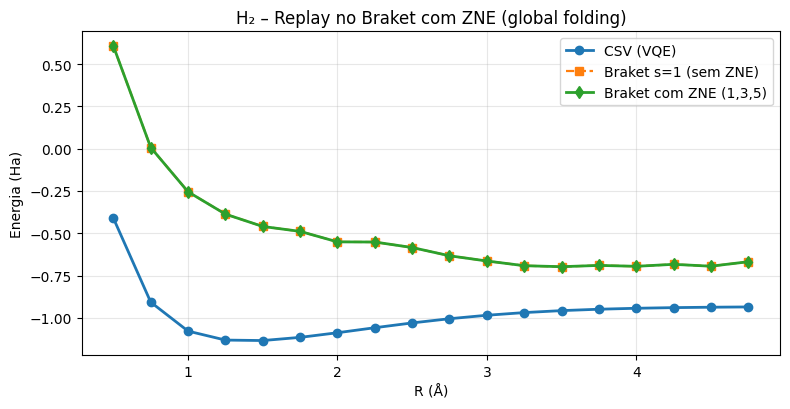

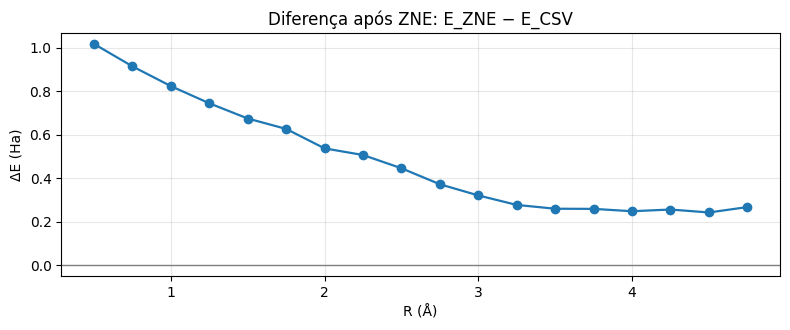

In [19]:
# =========================================================
# ZNE (global folding) para o seu replay no Braket
#   - Escalas s = 1,3,5  (U, U†U, U†U U†U)
#   - Extrapolação (ordem 2) via ajuste quadrático em s
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import qchem

# ----------------- CONFIG -----------------
csv_in  = "pes_vqe_resultados.csv"
csv_out = "pes_vqe_replay_qpu_zne.csv"

shots = 2000   # aumente se puder (em QPU real, 2k–10k por ponto costuma ser ok)

# ---------- H2 HAMILTONIAN (iguais ao VQE do CSV) ----------
symbols = ["H", "H"]
charge  = 0
mult    = 1
basis   = "sto-3g"

# wire/order -> igual ao seu VQE (quatro spin-orbitais)
# r será passado a cada ponto do CSV, mas o replay só precisa de H para cada r;
# como você está reusando os ângulos do CSV, vamos usar o mesmo r apenas para reconstruir H.
def h2_hamiltonian(r_bohr: float):
    coords = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r_bohr])
    H, n_qubits = qchem.molecular_hamiltonian(
        symbols, coords, method="pyscf", basis=basis, charge=charge, mult=mult
    )
    return H, n_qubits

# Estado HF para H2 (2 elétrons em 4 spin-orbitais -> |1100>)
hf = qchem.hf_state(electrons=2, orbitals=4)

# --------- ANSATZ = o mesmo do VQE (3 parâmetros) ----------
def apply_block(theta):
    """Bloco U(theta) — exatamente o que você usou no VQE."""
    qml.DoubleExcitation(theta[0], wires=[0, 1, 2, 3])
    qml.SingleExcitation(theta[1], wires=[0, 2])
    qml.SingleExcitation(theta[2], wires=[1, 3])

def apply_block_inverse(theta):
    """U†(theta): inverte o bloco (ângulos com sinal trocado; CZ não aparece no seu ansatz)."""
    # ordem inversa e sinais trocados
    qml.SingleExcitation(-theta[2], wires=[1, 3])
    qml.SingleExcitation(-theta[1], wires=[0, 2])
    qml.DoubleExcitation(-theta[0], wires=[0, 1, 2, 3])

def apply_folding(theta, scale_s: int):
    """
    Aplica folding global:
      s=1 -> U
      s=3 -> U · U† · U
      s=5 -> U · (U†·U) · (U†·U)
    """
    if scale_s % 2 == 0 or scale_s < 1:
        raise ValueError("scale_s deve ser ímpar: 1,3,5,...")
    apply_block(theta)
    k = (scale_s - 1) // 2
    for _ in range(k):
        apply_block_inverse(theta)
        apply_block(theta)

# --------- QNode (Braket com grouping QWC) ----------
def build_qnode(H, shots):
    dev = qml.device("braket.aws.qubit", device_arn=device_arn, wires=4, shots=shots)

    @qml.qnode(dev, interface="autograd")
    def energy_at(theta, scale_s: int):
        qml.BasisState(hf, wires=[0, 1, 2, 3])
        apply_folding(theta, scale_s)
        return qml.expval(H)

    return energy_at

# --------- Extrapolação Richardson (ordem 2) ----------
def zne_richardson_s_to_1(scales, values):
    """
    Ajuste quadrático E(s) ~ a + b*(s-1) + c*(s-1)^2  -> retorna a (s->1)
    scales: array-like (p.ex. [1,3,5])
    values: energias medidas nesses scales
    """
    s = np.asarray(scales, dtype=float)
    x = s - 1.0
    V = np.vstack([np.ones_like(x), x, x**2]).T
    coeffs, *_ = np.linalg.lstsq(V, np.asarray(values, dtype=float), rcond=None)
    a, b, c = coeffs
    return float(a)

# ------------- MAIN: ler CSV, rodar ZNE -------------
df = pd.read_csv(csv_in)
df.columns = ["R (Å)", "Energia_sim (Ha)", "Ângulo θ (rad)"]

# converter Å -> Bohr para reconstruir H corretamente
ANGS_TO_BOHR = 1.0 / 0.529177210903

scales = [1, 3, 5]   # pode aumentar (7,9...) se quiser, mas custo cresce
E_noisy_list = []
E_zne_list   = []

for i, row in df.iterrows():
    R_ang = float(row["R (Å)"])
    theta0 = float(row["Ângulo θ (rad)"])
    # seu VQE usa 3 parâmetros; aqui guardamos theta0 nos três para reproduzir seu ansatz simplificado
    theta_vec = np.array([theta0, theta0, theta0], dtype=float)

    # Reconstrói H(r) em cada ponto (para comparar com CSV ponto-a-ponto)
    H, n_qubits = h2_hamiltonian(R_ang * ANGS_TO_BOHR)
    qnode = build_qnode(H, shots)

    # mede E(s) nas escalas escolhidas
    E_vals = []
    for s in scales:
        E_s = float(qnode(theta_vec, s))
        E_vals.append(E_s)

    # salva não-mitigado e mitigado
    E_noisy_list.append(E_vals[0])                 # s = 1
    E_zne_list.append(zne_richardson_s_to_1(scales, E_vals))

    print(f"{i+1:02d}/{len(df)}  R={R_ang:.2f} Å | "
          f"E(s=1)={E_vals[0]: .6f}  E_ZNE={E_zne_list[-1]: .6f}  "
          f"[E3={E_vals[1]: .6f}, E5={E_vals[2]: .6f}]")

df["Energia_Braket (s=1)"] = E_noisy_list
df["Energia_ZNE"]          = E_zne_list
df["ΔE(ZNE - CSV)"]        = df["Energia_ZNE"] - df["Energia_sim (Ha)"]
df.to_csv(csv_out, index=False)
print(f"\n💾 Salvo em: {csv_out}")

# ------------- PLOTS -------------
plt.figure(figsize=(8,4.2))
plt.plot(df["R (Å)"], df["Energia_sim (Ha)"], "o-", lw=2, label="CSV (VQE)")
plt.plot(df["R (Å)"], df["Energia_Braket (s=1)"], "s--", lw=1.6, label="Braket s=1 (sem ZNE)")
plt.plot(df["R (Å)"], df["Energia_ZNE"], "d-", lw=2, label="Braket com ZNE (1,3,5)")
plt.xlabel("R (Å)"); plt.ylabel("Energia (Ha)")
plt.title("H₂ – Replay no Braket com ZNE (global folding)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3.4))
plt.plot(df["R (Å)"], df["ΔE(ZNE - CSV)"], "o-", lw=1.6)
plt.axhline(0, color="gray", lw=1)
plt.xlabel("R (Å)"); plt.ylabel("ΔE (Ha)")
plt.title("Diferença após ZNE: E_ZNE − E_CSV")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

In [ ]:
# ==== 5) Exemplo: varrer uma lista de ângulos (p.ex. os do seu CSV) ==
# Troque por suas instâncias: lista de (R, theta, phi)
scan = [
    (0.50, 1.27, 0.00),
    (0.75, 1.27, 0.00),
    (1.00, 1.27, 0.00),
    # ... adicione as linhas que você exportou
]

rows = []
for R, th, ph in scan:
    E, exps = run_energy(th, ph, shots=2000)
    rows.append((R, th, ph, E))
    print(f"R={R:>5.2f} Å | theta={th:>6.3f} | phi={ph:>6.3f} | E_QPU≈ {E: .6f} Ha")

# ==== 6) (Opcional) Comparar com energia simulada ===================
# Se você tiver um CSV com “R, E_sim, theta, phi”, você pode juntar:
# - Carregue seu CSV, faça um dict {R: (E_sim, theta, phi)}
# - Rodar run_energy para cada R lendo theta/phi
# - Plotar E_QPU vs E_sim e (E_QPU - E_sim)

In [6]:
# === H2 VQE (replay no QPU): lê CSV, executa no backend escolhido e compara ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import qchem

# -------------------------------------------------------
# 0) Configurações do backend (troque só aqui)
# -------------------------------------------------------

shots = 2000                        # nº de amostras por ponto
grouping_type = "qwc"               # agrupa Pauli-terms para reduzir tasks
basis = "sto-3g"                    # mesmo da simulação
csv_in = "pes_vqe_resultados.csv"   # arquivo que você salvou antes
csv_out = "pes_vqe_qpu_resultados.csv"


In [7]:
# -------------------------------------------------------
# 1) Ler CSV (R Å, Energia_sim Ha, theta rad)
# -------------------------------------------------------
df = pd.read_csv(csv_in)
if not {"R (Å)", "Energia (Ha)", "Ângulo θ (rad)"}.issubset(df.columns):
    # compatibilidade com cabeçalhos diferentes
    df.columns = ["R (Å)", "Energia (Ha)", "Ângulo θ (rad)"][: len(df.columns)]

R_list = df["R (Å)"].to_numpy(dtype=float)
E_sim  = df["Energia (Ha)"].to_numpy(dtype=float)
theta_list = df["Ângulo θ (rad)"].to_numpy(dtype=float)


In [8]:
# -------------------------------------------------------
# 2) Funções utilitárias (H2 + QNode com o ângulo salvo)
# -------------------------------------------------------
symbols = ["H", "H"]

def ham_h2_for_R(R_angstrom):
    """Constrói H (qubit Hamiltonian) para H2 a distância R (Å)."""
    coords = np.array([0.0, 0.0, 0.0,   0.0, 0.0, R_angstrom])  # H at (0,0,0) and (0,0,R)
    H, n_qubits = qchem.molecular_hamiltonian(
        symbols,
        coords,
        method="pyscf",
        basis=basis,
        mapping="jordan_wigner",
        charge=0,
        mult=1,
        outpath=None,
    )
    return H, n_qubits

def make_qnode(H, n_qubits, theta):
    """Cria um QNode que aplica o ansatz usado (mesmo layout) e mede ⟨H⟩."""
    # HF |1100> para H2 em STO-3G (2 elétrons, 4 spin-orbitais)
    hf = qchem.hf_state(electrons=2, orbitals=n_qubits)

    dev = qml.device(
        "braket.aws.qubit",
        device_arn=device_arn,
        wires=n_qubits,
        shots=shots,
    )

    @qml.qnode(dev, interface="autograd")
    def circuit():
        # mesmo ansatz da sua simulação: Double + Singles
        qml.BasisState(hf, wires=range(n_qubits))
        qml.DoubleExcitation(theta, wires=[0, 1, 2, 3])
        # Como na sua “replay” você salvou 1 ângulo, mantemos os singles zerados (replay fiel)
        qml.SingleExcitation(0.0, wires=[0, 2])
        qml.SingleExcitation(0.0, wires=[1, 3])
        return qml.expval(H)

    return circuit


In [9]:
# -------------------------------------------------------
# 3) Executar para cada linha e coletar E_qpu
# -------------------------------------------------------
E_qpu = []
for i, (R, theta) in enumerate(zip(R_list, theta_list), 1):
    H, n_qubits = ham_h2_for_R(R)

    # dica: agrupa medição para reduzir nº de tasks
    H = qml.pauli.group_observables([H], grouping_type=grouping_type)[0][0]

    circuit = make_qnode(H, n_qubits, theta)

    print(f"[{i:02d}/{len(R_list)}] R = {R:.3f} Å | θ = {theta:.6f} rad -> executando…")
    E = float(circuit())
    E_qpu.append(E)

print("✅ execuções concluídas.")


TypeError: Expected a Pauli word Operator instance, instead got 1.582228141671702 * I([0, 2, 1, 3]) + 0.2671953888229382 * Z(0) + -0.5854334243389849 * Z(2) + 0.14685523706503772 * (Z(0) @ Z(2)) + 0.26719538882293814 * Z(1) + 0.18917415505208923 * (Z(0) @ Z(1)) + 0.03992574746330457 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.03992574746330457 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.03992574746330457 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.03992574746330457 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.5854334243389848 * Z(3) + 0.1867809845283424 * (Z(0) @ Z(3)) + 0.14685523706503772 * (Z(1) @ Z(3)) + 0.1867809845283424 * (Z(1) @ Z(2)) + 0.19780133118579402 * (Z(2) @ Z(3)).

In [ ]:
# -------------------------------------------------------
# 4) Salvar CSV com QPU e diferença
# -------------------------------------------------------
df_out = df.copy()
df_out["Energia QPU (Ha)"] = np.array(E_qpu, dtype=float)
df_out["ΔE (QPU - Sim) [Ha]"] = df_out["Energia QPU (Ha)"] - df_out["Energia (Ha)"]
df_out.to_csv(csv_out, index=False)
print(f"💾 salvo: {csv_out}")

# -------------------------------------------------------
# 5) Plot comparar (sim vs qpu) + erro
# -------------------------------------------------------
plt.figure(figsize=(7.5, 4.8))
plt.plot(R_list, E_sim, "-o", label="Sim (replay)", lw=2)
plt.plot(R_list, E_qpu, "-o", label="QPU/SV1", lw=2)
plt.xlabel("Bond length R (Å)")
plt.ylabel("Total energy (Hartree)")
plt.title("H$_2$ – Energies (Sim vs QPU)")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7.5, 3.2))
plt.plot(R_list, df_out["ΔE (QPU - Sim) [Ha]"], "-o")
plt.axhline(0.0, color="gray", lw=1)
plt.xlabel("Bond length R (Å)")
plt.ylabel("ΔE (Ha)")
plt.title("H$_2$ – Pointwise energy difference (QPU − Sim)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()